# Робота на тему :
# "Розпізнавання рукописного тексту на основі нейронних мереж"*
***
## *Виконав студент 4 курсу*
## *Групи АнД-41*
## *Сірий Артем Олександрович*

In [202]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import random
import glob
import os
import h5py
import matplotlib.pyplot as plt
import imageio
import cv2
from keras.models import save_model, load_model
import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LeakyReLU,GlobalMaxPooling2D
from tensorflow.keras.metrics import top_k_categorical_accuracy,categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

In [2]:
import tensorflow as tf
tf.config.list_physical_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3498181884366180529
xla_global_id: -1
]


In [4]:
def import_data(CSV_FILE):
    data = pd.read_csv(PATH_TO_DATA + CSV_FILE)
    # Create path extention for corresponding folders that contains images 
    data['source'] = CSV_FILE[:-4]+'/'
    return data

def ohe_letters(label):
    '''
    One hot encoding for the target label
    '''
    resu = np.zeros(len(letters))
    index = letters.index(label)
    resu[index] = 1
    return resu

def ohe_backgrounds(label):
    '''
    One hot encoding for background column
    '''
    resu = np.zeros(len(data.background.unique()))
    resu[label] = 1
    return resu

def display_image(images_list, list_of_labels = np.arange(9)):
    
    # plot first few images
    plt.figure(figsize=(12,12))
    for index in list_of_labels:
        
        # Get corresponding label
        ohe_label = encoded_labels[index]
        index_letter = list(ohe_label).index(1)
        associated_letter = letters[index_letter]

        # Get background
        associated_background = backgrounds[index]
        
        
        # define subplot
        plt.subplot(330 + 1 + index)
        plt.title('Label: %s \n'%associated_letter+\
                 'Background: %s\n'%associated_background,
                 fontsize=18)
        # plot raw pixel data
        plt.imshow(images[index])
        
    plt.subplots_adjust(bottom = 0.001)  # the bottom of the subplots of the figure
    plt.subplots_adjust(top = 0.99)
    # show the figure
    plt.show()

In [5]:
def CNN_model(activation = 'softmax', 
              loss = 'categorical_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy']):
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size = (3, 3),
                     activation = 'relu',
                     input_shape = INPUT_SHAPE))
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(Conv2D(128, (4, 4), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.25))
    model.add(Dense(NUM_CLASSES, activation = activation))
    
    # Compile the model
    model.compile(loss = loss,
                  optimizer = optimizer, 
                  metrics = metrics)
    
    return model

In [6]:
def load_image(path_filename):
    # load the image
    img = load_img(path_filename, target_size=(32, 32))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 1 channel
    img = img.reshape(1, 32, 32, 3)
    # prepare pixel data
    img = img.astype('float32')
    img = img / 255.0
    return img

def get_true_label(path_filename, dataframe, column_to_get):
    filename = os.path.basename(os.path.normpath(path_filename))
    index_row = data[data['file']==filename].index[0]
    return data.loc[index_row, column_to_get]

def load_random_images(number_of_images_to_load = 9):
    images = []
    true_labels = []
    true_backgrounds = []
    
    which_folder = [random.randint(1,3) for _ in range(number_of_images_to_load)]
    for index_folder in which_folder:
        if index_folder == 1:
            path = PATH_TO_DATA+'letters/'
        else:
            path = PATH_TO_DATA+'letters'+str(index_folder)+'/'
        nb_files = len(os.listdir(path))
        
        index_image = random.randint(0, len(os.listdir(path)))
        
        image = load_image(path + os.listdir(path)[index_image])
        label = get_true_label(path + os.listdir(path)[index_image], data, 'letter')
        background = get_true_label(path + os.listdir(path)[index_image], data, 'background')

        images.append(image)
        true_labels.append(label)
        true_backgrounds.append(background)
        
    return images, true_labels, true_backgrounds

def classes_predictions(images_list_to_classify, true_labels, model):
    
    # plot first few images
    plt.figure(figsize=(12,12))
    for index, image in enumerate(images_list_to_classify):
        
        a_letter = model.predict(image)
        associated_letter = letters[a_letter.argmax()]
        
        # define subplot
        plt.subplot(330 + 1 + index)
        plt.title('Predicted Label: %s \n'%associated_letter+\
                  'True Label: %s\n'%true_labels[index],
                 fontsize=18)
        # plot raw pixel data
        plt.imshow(image[0])
        
    plt.subplots_adjust(bottom = 0.001)  # the bottom of the subplots of the figure
    plt.subplots_adjust(top = 0.99)
        
    # show the figure
    plt.show()

## Load data

In [242]:
PATH_TO_DATA = 'input/'
CSV_FILES =  ['letters.csv', 'letters2.csv', 'letters3.csv']
data1 = import_data(CSV_FILES[0])
data2 = import_data(CSV_FILES[1])
data3 = import_data(CSV_FILES[2])
data = pd.concat([data1, data2, data3], ignore_index=True)

print("First dataset shape: {0}, \nSecond dataset shape: {1}, \nThird dataset shape: {2}, \nFull volume: 14190".format(data1.shape, data2.shape, data3.shape))

First dataset shape: (1650, 5), 
Second dataset shape: (5940, 5), 
Third dataset shape: (6600, 5)


In [243]:
data = shuffle(data, random_state = 42)
data.head()

,letter,label,file,background,source
6491,щ,27,27_212.png,2,letters2/
2012,в,3,03_53.png,2,letters2/
13295,ы,29,29_336.png,3,letters3/
11270,с,19,19_311.png,3,letters3/
12837,щ,27,27_278.png,3,letters3/


In [244]:
# Get all labels in one string
letters = '' 
for letter in data.letter.unique():
    letters += letter
    
# Which letter is written on each image
labels = data.label

In [245]:
data['encoded_letter'] = data['letter'].apply(lambda x:ohe_letters(x))
data['encoded_background'] = data['background'].apply(lambda x:ohe_backgrounds(x))
data.head(10)

,letter,label,file,background,source,encoded_letter,encoded_background
6491,щ,27,27_212.png,2,letters2/,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0]"
2012,в,3,03_53.png,2,letters2/,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0]"
13295,ы,29,29_336.png,3,letters3/,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0]"
11270,с,19,19_311.png,3,letters3/,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0]"
12837,щ,27,27_278.png,3,letters3/,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0]"
3817,л,13,13_58.png,2,letters2/,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0]"
7529,я,33,33_170.png,2,letters2/,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0]"
12389,ц,24,24_430.png,3,letters3/,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0]"
9450,и,10,10_291.png,3,letters3/,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0]"
13941,ю,32,32_382.png,3,letters3/,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 1.0]"


## Normalize

In [246]:
# Store all png images into one numpy array
images = []
# Will be the target
encoded_labels = []

backgrounds = []
encoded_backgrounds = []

# I want to be sure that every image is consitent
for i, row in data.iterrows():
    img_name = row['file']
    numpy_image = cv2.imread(os.path.join(PATH_TO_DATA + row['source'], img_name))
    if numpy_image.shape == (32, 32, 3):
        images.append(numpy_image)
        encoded_labels.append(row['encoded_letter'])
        backgrounds.append(row['background'])
        encoded_backgrounds.append(row['encoded_background'])
        
# Normalize array of images
images = np.array(images)/255
print(images)

[[[[0.68235294 0.6745098  0.73333333]
   [0.67843137 0.67058824 0.7254902 ]
   [0.6745098  0.67058824 0.7254902 ]
   ...
   [0.64313725 0.64313725 0.70588235]
   [0.64313725 0.64313725 0.70588235]
   [0.63921569 0.64313725 0.70588235]]

  [[0.67843137 0.6745098  0.72941176]
   [0.6745098  0.67058824 0.7254902 ]
   [0.67843137 0.6745098  0.72941176]
   ...
   [0.64313725 0.64705882 0.70588235]
   [0.64313725 0.64313725 0.70588235]
   [0.63921569 0.63921569 0.70196078]]

  [[0.67058824 0.6745098  0.72941176]
   [0.67058824 0.67058824 0.7254902 ]
   [0.67843137 0.6745098  0.72941176]
   ...
   [0.64313725 0.64313725 0.70588235]
   [0.64313725 0.64313725 0.70588235]
   [0.63921569 0.63921569 0.70196078]]

  ...

  [[0.65490196 0.6627451  0.71372549]
   [0.65882353 0.6627451  0.71764706]
   [0.65882353 0.6627451  0.71764706]
   ...
   [0.62745098 0.62745098 0.69019608]
   [0.62745098 0.62745098 0.69019608]
   [0.62745098 0.62745098 0.69019608]]

  [[0.65882353 0.6627451  0.71764706]
   [0.6

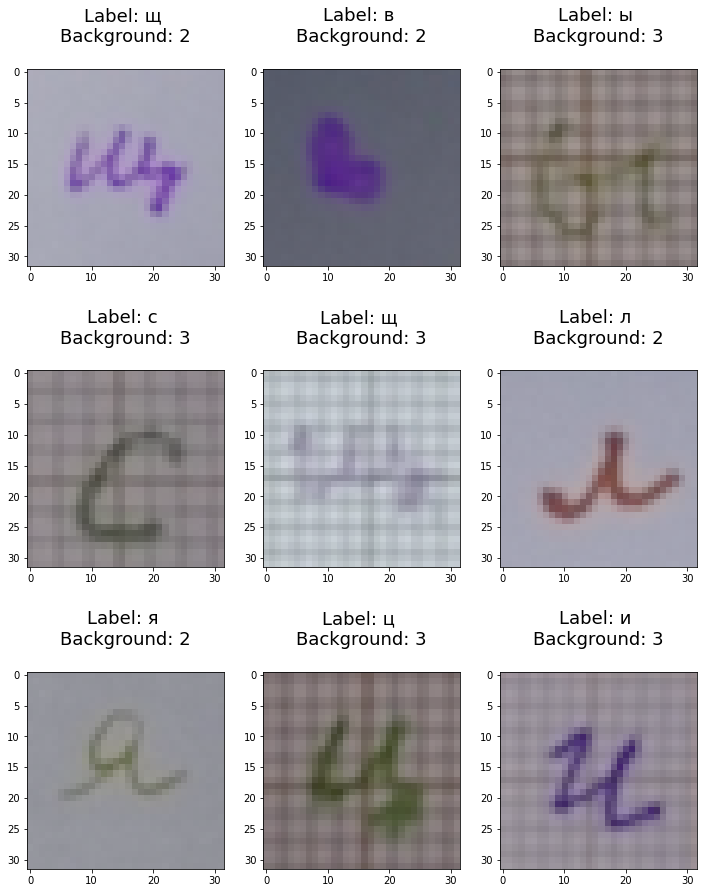

In [247]:
display_image(images)

In [248]:
# Define X_data and target
X = np.array(images.copy())
y = np.array(encoded_labels.copy())

# Stratified train_test split on labels
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=.2, 
                                                  stratify = y, 
                                                  random_state=42)

In [251]:
print(X)

[[[[0.68235294 0.6745098  0.73333333]
   [0.67843137 0.67058824 0.7254902 ]
   [0.6745098  0.67058824 0.7254902 ]
   ...
   [0.64313725 0.64313725 0.70588235]
   [0.64313725 0.64313725 0.70588235]
   [0.63921569 0.64313725 0.70588235]]

  [[0.67843137 0.6745098  0.72941176]
   [0.6745098  0.67058824 0.7254902 ]
   [0.67843137 0.6745098  0.72941176]
   ...
   [0.64313725 0.64705882 0.70588235]
   [0.64313725 0.64313725 0.70588235]
   [0.63921569 0.63921569 0.70196078]]

  [[0.67058824 0.6745098  0.72941176]
   [0.67058824 0.67058824 0.7254902 ]
   [0.67843137 0.6745098  0.72941176]
   ...
   [0.64313725 0.64313725 0.70588235]
   [0.64313725 0.64313725 0.70588235]
   [0.63921569 0.63921569 0.70196078]]

  ...

  [[0.65490196 0.6627451  0.71372549]
   [0.65882353 0.6627451  0.71764706]
   [0.65882353 0.6627451  0.71764706]
   ...
   [0.62745098 0.62745098 0.69019608]
   [0.62745098 0.62745098 0.69019608]
   [0.62745098 0.62745098 0.69019608]]

  [[0.65882353 0.6627451  0.71764706]
   [0.6

In [252]:
print(y)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [14]:
# Define image dimensions
IMG_ROWS = 32
IMG_COLS = 32
# 3 stands for RGB images, 1 if greyscaled images
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, 3)

# Number of classes to consider
NUM_CLASSES = len(letters)
# Group of training samples
BATCH_SIZE = 64
# Number of complete presentations of the dataset to be learned
EPOCHS = 10

In [15]:
#def top_3_categorical_accuracy(y_true, y_pred):
    #return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [16]:
# Init CNN model
cnn_model = CNN_model()

# Save weights only for best model
checkpointer = ModelCheckpoint(filepath = 'weights.best.letters.hdf5', 
                               verbose = 2, 
                               save_best_only = True)

# Reduce learning rate when a metric has stopped improving
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=10, 
                                 verbose=2, 
                                 factor=.75)

# If score doesn't improve during patience=20 epochs, stop learning
estopping = EarlyStopping(monitor='val_loss', 
                          patience=20, 
                          verbose=2)

# Training
history = cnn_model.fit(X_train, y_train,
                        batch_size = BATCH_SIZE,
                        epochs = EPOCHS,
                        verbose = 1,
                        validation_data = (X_val, y_val),
                        callbacks = [checkpointer, lr_reduction, estopping])

Epoch 1/10
178/178 [==============================] - ETA: 0s - loss: 3.4107 - accuracy: 0.0617
Epoch 00001: val_loss improved from inf to 2.89169, saving model to weights.best.letters.hdf5
178/178 [==============================] - 28s 157ms/step - loss: 3.4107 - accuracy: 0.0617 - val_loss: 2.8917 - val_accuracy: 0.2299 - lr: 0.0010
Epoch 2/10
178/178 [==============================] - ETA: 0s - loss: 2.5735 - accuracy: 0.2665
Epoch 00002: val_loss improved from 2.89169 to 2.09774, saving model to weights.best.letters.hdf5
178/178 [==============================] - 28s 157ms/step - loss: 2.5735 - accuracy: 0.2665 - val_loss: 2.0977 - val_accuracy: 0.4200 - lr: 0.0010
Epoch 3/10
178/178 [==============================] - ETA: 0s - loss: 2.0619 - accuracy: 0.4065
Epoch 00003: val_loss improved from 2.09774 to 1.64410, saving model to weights.best.letters.hdf5
178/178 [==============================] - 28s 159ms/step - loss: 2.0619 - accuracy: 0.4065 - val_loss: 1.6441 - val_accuracy: 0

<AxesSubplot:>

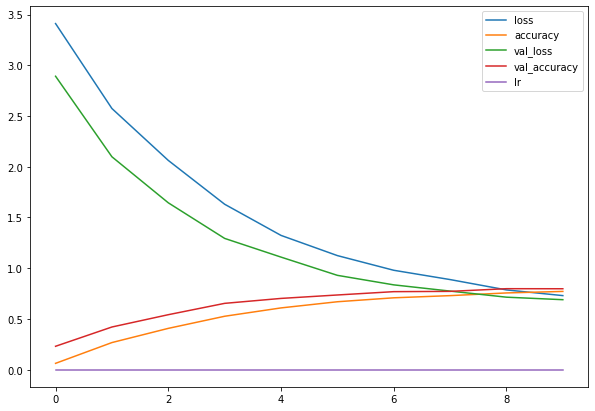

In [17]:
pd.DataFrame(history.history).plot(figsize=(10, 7))

In [18]:
# Evaluation
# loading the model with the best validation accuracy
cnn_model.load_weights('weights.best.letters.hdf5')
cnn_model.evaluate(X_val, y_val)

89/89 [==============================] - 2s 19ms/step - loss: 0.6892 - accuracy: 0.7969


[0.6891568303108215, 0.7968970537185669]

In [19]:
class_rnd = random.randint(1,33)
num_rnd = random.randint(231,430)
if(class_rnd<10):
    img = load_image(PATH_TO_DATA+'letters3/0{0}_{1}.png'.format(class_rnd,num_rnd))
else:
    img = load_image(PATH_TO_DATA+'letters3/{0}_{1}.png'.format(class_rnd,num_rnd))

predicted: а
true label: а


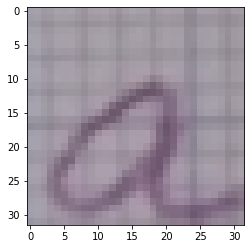

In [20]:
# predict the class

a_letter = cnn_model.predict(img) 
a_letter_classes=np.argmax(a_letter,axis=1)

plt.imshow(img[0])
print('predicted:', letters[a_letter.argmax()])
if(class_rnd<10):
    print('true label:', get_true_label(PATH_TO_DATA+'letters3/0{0}_{1}.png'.format(class_rnd,num_rnd), data, 'letter'))
else:
    print('true label:', get_true_label(PATH_TO_DATA+'letters3/{0}_{1}.png'.format(class_rnd,num_rnd), data, 'letter'))

In [21]:
test_images, true_labels, true_backgrounds = load_random_images()

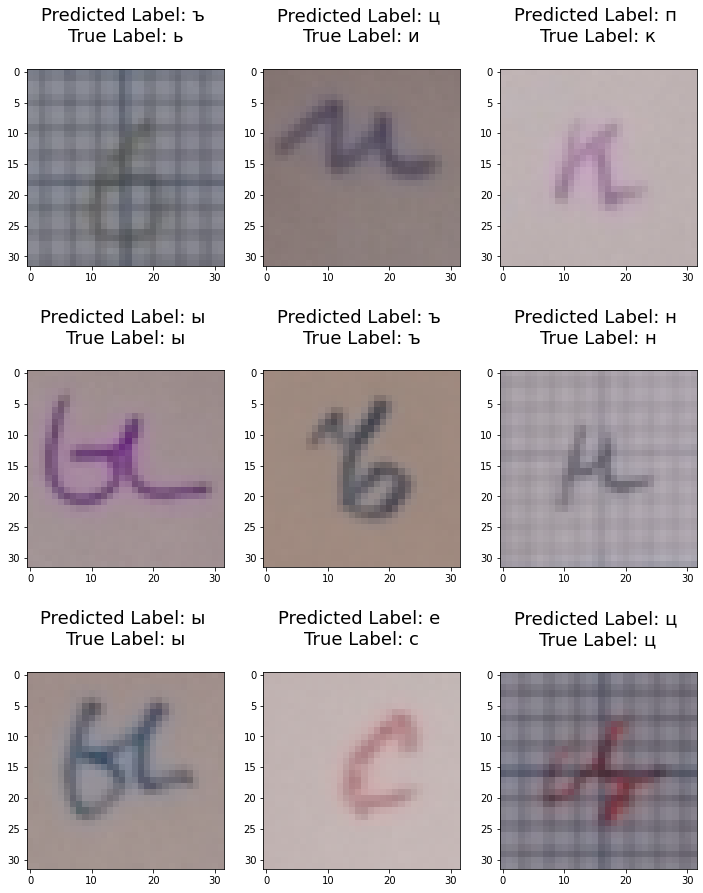

In [22]:
classes_predictions(test_images, true_labels, cnn_model)

In [83]:
def normal_and_predict_img():
    image = Image.open("temp.jpg")
    image = image.resize((32,32),Image.ANTIALIAS)
    numpy_image = np.array(image)/255
    numpy_image = np.expand_dims(numpy_image, axis=0)
    a_letter = cnn_model.predict(numpy_image)
    #sorted(a_letter, reverse=True)
    return a_letter

In [270]:
def model_update(label_list,):
    cnn_model.save('cnn_model')

    #Load img
    d = {'а':1,'б':2,'в':3,'г':4,'д':5,'е':6,'ё':7,'ж':8,'з':9,'и':10,'й':11,'к':12,'л':13,'м':14,'н':15,'о':16,'п':17,'р':18,'с':19,'т':20,'у':21,'ф':22,'х':23,'ц':24,'ч':25,'ш':26,'щ':27,'ъ':28,'ы':29,'ь':30,'э':31,'ю':32,'я':33}
    data_new = pd.DataFrame(columns=['letter', 'label', 'file'])
    for i in range(len(label_list)):
        data_new = data_new.append({'letter': label_list[i], 'label': d[label_list[i]], 'file': 'temp_'+str(i)+'.jpg'}, ignore_index=True)
    data_new = shuffle(data_new, random_state = 42)
    data_new['encoded_letter'] = data_new['letter'].apply(lambda x:ohe_letters(x))

    images = []
    encoded_labels = []
    PATH_TO_DATA = 'up_train/'
    for i, row in data_new.iterrows():
        img_name = row['file']
        image = Image.open("up_train/"+str(img_name))
        image = image.resize((32,32),Image.ANTIALIAS)
        numpy_image = np.array(image)/255
        if numpy_image.shape == (32, 32, 3):
            images.append(numpy_image)
            encoded_labels.append(row['encoded_letter'])

    # Define X_data and target
    X = np.array(images.copy())
    y = np.array(encoded_labels.copy())

    # Stratified train_test split on labels
    X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                      test_size=.2, 
                                                      stratify = y, 
                                                      random_state=42)        

    #load model
    cnn_model = keras.models.load_model('cnn_model')
    history2 = cnn_model.fit(X_train, y_train,
                            batch_size = BATCH_SIZE,
                            epochs = EPOCHS,
                            verbose = 1,
                            validation_data = (X_val, y_val),
                            callbacks = [checkpointer, lr_reduction, estopping])

INFO:tensorflow:Assets written to: cnn_model\assets
Epoch 1/10
1/1 [==============================] - ETA: 0s - loss: 3.1561 - accuracy: 0.5909
Epoch 00001: val_loss did not improve from 0.68916
1/1 [==============================] - 0s 454ms/step - loss: 3.1561 - accuracy: 0.5909 - val_loss: 1.3567 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/10
1/1 [==============================] - ETA: 0s - loss: 3.3466 - accuracy: 0.6364
Epoch 00002: val_loss did not improve from 0.68916
1/1 [==============================] - 0s 95ms/step - loss: 3.3466 - accuracy: 0.6364 - val_loss: 2.0270 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 3/10
1/1 [==============================] - ETA: 0s - loss: 1.8395 - accuracy: 0.7727
Epoch 00003: val_loss did not improve from 0.68916
1/1 [==============================] - 0s 95ms/step - loss: 1.8395 - accuracy: 0.7727 - val_loss: 2.2784 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 4/10
1/1 [==============================] - ETA: 0s - loss: 1.5747 - accuracy: 0.7727
Epo

In [262]:
import tkinter as tk
from tkinter import *
from PIL import Image,ImageDraw
global temp, label_list
temp=0
label_list = []
class ImageGenerator:
    def __init__(self,parent,posx,posy,*kwargs):
        self.parent = parent
        self.posx = posx
        self.posy = posy
        self.sizex = 200
        self.sizey = 200
        self.b1 = "up"
        self.xold = None
        self.yold = None 
        self.drawing_area=tk.Canvas(self.parent,width=self.sizex,height=self.sizey)
        self.drawing_area.place(x=self.posx,y=self.posy)
        self.drawing_area.bind("<Motion>", self.motion)
        self.drawing_area.bind("<ButtonPress-1>", self.b1down)
        self.drawing_area.bind("<ButtonRelease-1>", self.b1up)
        self.button=tk.Button(self.parent,text="Predict!",width=10,bg='white',command=self.save)
        self.button.place(x=self.sizex/7,y=self.sizey+20)
        self.button1=tk.Button(self.parent,text="Clear!",width=10,bg='white',command=self.clear)
        self.button1.place(x=(self.sizex/7)+80,y=self.sizey+20)
        self.button2=tk.Button(self.parent,text="Add to folder!",width=10,bg='white',command=self.save_to_train)
        self.button2.place(x=self.sizex/7,y=self.sizey+45)
        self.button3=tk.Button(self.parent,text="Train a model!",width=10,bg='white',command=self.train_mod)
        self.button3.place(x=(self.sizex/7)+80,y=self.sizey+45)
        
        self.my_label = Label(root, text='')
        self.my_label.place(x=35, y=280)
        self.my_label_2 = Label(root, text='')
        self.my_label_2.place(x=35, y=300)
        self.my_label_3 = Label(root, text='')
        self.my_label_3.place(x=35, y=320)
        self.my_label_4 = Label(root, text='')
        self.my_label_4.place(x=270, y=20)
        self.my_label_4.config(text="Введіть літеру")
        
        self.message = StringVar()
        self.name_entry = Entry(textvariable=self.message)
        self.name_entry.grid(row=0,column=1, padx=250, pady=40)
        
        self.image=Image.new("RGB",(200,200),(255,255,255))
        self.draw=ImageDraw.Draw(self.image)    
    
    def save(self):
        filename = "temp.jpg"
        self.image.save(filename)
        a_letter = normal_and_predict_img()
        self.my_label.config(text="Зпрогнозована літера : "+ letters[a_letter.argmax()] + " | " + str(a_letter[0][a_letter.argmax()]))
        a_letter = np.delete(a_letter, np.argmax(a_letter[:a_letter.argmax()+1]))
        self.my_label_2.config(text="Вірогідна літера : "+ letters[a_letter.argmax()] + " | " + str(a_letter[a_letter.argmax()]))
        a_letter = np.delete(a_letter, np.argmax(a_letter[:a_letter.argmax()+1]))
        self.my_label_3.config(text="Вірогідна літера : "+ letters[a_letter.argmax()] + " | " + str(a_letter[a_letter.argmax()]))

    def clear(self):
        self.drawing_area.delete("all")
        self.image=Image.new("RGB",(200,200),(255,255,255))
        self.draw=ImageDraw.Draw(self.image)

    def save_to_train(self):
        global temp, label_list
        filename = "up_train/temp_"+str(temp)+".jpg"
        self.image.save(filename)
        label_list.append(self.message.get())
        temp+=1
        print(filename)
    
    def train_mod(self):
        model_update(label_list)
        
    def b1down(self,event):
        self.b1 = "down"

    def b1up(self,event):
        self.b1 = "up"
        self.xold = None
        self.yold = None
    
    def motion(self,event):
        if self.b1 == "down":
            if self.xold is not None and self.yold is not None:
                event.widget.create_line(self.xold,self.yold,event.x,event.y,smooth='true',width=3,fill='blue')
                self.draw.line(((self.xold,self.yold),(event.x,event.y)),(0,128,0),width=5)

        self.xold = event.x
        self.yold = event.y

if __name__ == "__main__":
    root=tk.Tk()
    root.wm_geometry("%dx%d+%d+%d" % (400, 400, 10, 10))
    root.config(bg='white')
    ImageGenerator(root,10,10)
    root.mainloop()

up_train/temp_0.jpg
up_train/temp_1.jpg
up_train/temp_2.jpg
up_train/temp_3.jpg
up_train/temp_4.jpg
up_train/temp_5.jpg
up_train/temp_6.jpg
up_train/temp_7.jpg
up_train/temp_8.jpg
up_train/temp_9.jpg
up_train/temp_10.jpg
up_train/temp_11.jpg
up_train/temp_12.jpg
up_train/temp_13.jpg
up_train/temp_14.jpg
up_train/temp_15.jpg
up_train/temp_16.jpg
up_train/temp_17.jpg
up_train/temp_18.jpg
up_train/temp_19.jpg
up_train/temp_20.jpg
up_train/temp_21.jpg
up_train/temp_22.jpg
up_train/temp_23.jpg
up_train/temp_24.jpg
up_train/temp_25.jpg
up_train/temp_26.jpg
up_train/temp_27.jpg


<AxesSubplot:>

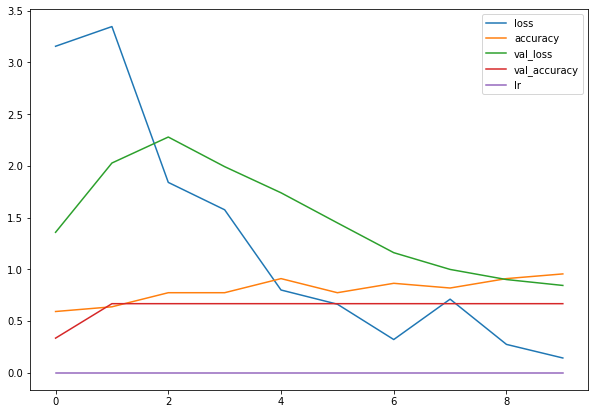

In [272]:
pd.DataFrame(history2.history).plot(figsize=(10, 7))

In [275]:
import tkinter as tk
from tkinter import *
from PIL import Image,ImageDraw
class ImageGenerator:
    def __init__(self,parent,posx,posy,*kwargs):
        self.parent = parent
        self.posx = posx
        self.posy = posy
        self.sizex = 200
        self.sizey = 200
        self.b1 = "up"
        self.xold = None
        self.yold = None 
        self.drawing_area=tk.Canvas(self.parent,width=self.sizex,height=self.sizey)
        self.drawing_area.place(x=self.posx,y=self.posy)
        self.drawing_area.bind("<Motion>", self.motion)
        self.drawing_area.bind("<ButtonPress-1>", self.b1down)
        self.drawing_area.bind("<ButtonRelease-1>", self.b1up)
        self.button=tk.Button(self.parent,text="Predict!",width=10,bg='white',command=self.save)
        self.button.place(x=self.sizex/7,y=self.sizey+20)
        self.button1=tk.Button(self.parent,text="Clear!",width=10,bg='white',command=self.clear)
        self.button1.place(x=(self.sizex/7)+80,y=self.sizey+20)
        
        self.my_label = Label(root, text='')
        self.my_label.place(x=35, y=280)
        self.my_label_2 = Label(root, text='')
        self.my_label_2.place(x=35, y=300)
        self.my_label_3 = Label(root, text='')
        self.my_label_3.place(x=35, y=320)
        
        self.image=Image.new("RGB",(200,200),(255,255,255))
        self.draw=ImageDraw.Draw(self.image)    
    
    def save(self):
        filename = "temp.jpg"
        self.image.save(filename)
        a_letter = normal_and_predict_img()
        self.my_label.config(text="Зпрогнозована літера : "+ letters[a_letter.argmax()] + " | " + str(a_letter[0][a_letter.argmax()]))
        a_letter = np.delete(a_letter, np.argmax(a_letter[:a_letter.argmax()+1]))
        self.my_label_2.config(text="Вірогідна літера : "+ letters[a_letter.argmax()] + " | " + str(a_letter[a_letter.argmax()]))
        a_letter = np.delete(a_letter, np.argmax(a_letter[:a_letter.argmax()+1]))
        self.my_label_3.config(text="Вірогідна літера : "+ letters[a_letter.argmax()] + " | " + str(a_letter[a_letter.argmax()]))

    def clear(self):
        self.drawing_area.delete("all")
        self.image=Image.new("RGB",(200,200),(255,255,255))
        self.draw=ImageDraw.Draw(self.image)
        
    def b1down(self,event):
        self.b1 = "down"

    def b1up(self,event):
        self.b1 = "up"
        self.xold = None
        self.yold = None
    
    def motion(self,event):
        if self.b1 == "down":
            if self.xold is not None and self.yold is not None:
                event.widget.create_line(self.xold,self.yold,event.x,event.y,smooth='true',width=3,fill='blue')
                self.draw.line(((self.xold,self.yold),(event.x,event.y)),(0,128,0),width=5)

        self.xold = event.x
        self.yold = event.y

if __name__ == "__main__":
    root=tk.Tk()
    root.wm_geometry("%dx%d+%d+%d" % (400, 400, 10, 10))
    root.config(bg='white')
    ImageGenerator(root,10,10)
    root.mainloop()